In [1]:
# Install necessary libraries if you haven't already
# !pip install transformers datasets torch accelerate matplotlib

import torch
import torch.nn.functional as F
from torch.optim import AdamW
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import warnings
from tqdm.auto import tqdm # For progress bar
import matplotlib.pyplot as plt # Import for optional plotting later
import math
import re
import datetime

In [15]:
from pytz import timezone
tz = timezone('EST')

In [22]:
# Suppress UserWarnings (often related to dependency versions)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Configuration ---
config = {
    "model_name": "distilgpt2",  # Using a smaller model for faster demonstration
    "learning_rate": 5e-6,     # Learning rate for AdamW optimizer (might need tuning)
    "batch_size": 8,           # Batch size
    "seed": 42,
    "target_length": 20,       # The desired output length
    "max_gen_length": 25,      # Max tokens to generate (allows space for EOS)
    "steps": 1000,              # Total number of training steps (increase for real training)
    "device": "cuda" if torch.cuda.is_available() else "cpu", # Use GPU if available
    "reward_type": "dense_closeness"
}

In [17]:
# Set seed for reproducibility
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config["seed"])

# --- Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(config["model_name"])
# Set pad token if it's not already set (GPT2 often uses EOS as PAD)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# --- Model ---
print(f"Loading model on device: {config['device']}...")
# Load the base Causal LM model (no value head needed for REINFORCE)
model = AutoModelForCausalLM.from_pretrained(
    config["model_name"],
)
# Explicitly move model to the target device
model.to(config["device"])

print(f"Model loaded on device: {next(model.parameters()).device}") # Check actual device

# --- Optimizer ---
optimizer = AdamW(model.parameters(), lr=config["learning_rate"])

# --- Dataset ---
# Create a simple dataset of prompts
prompts = ["<|startoftext|> What is the time in hh:mm?"]
# Repeat prompts to easily form batches
num_repeats = (config["batch_size"] // len(prompts)) + 1
dataset_dict = {"query": prompts * num_repeats}
dataset = Dataset.from_dict(dataset_dict).shuffle(seed=config["seed"]) # Shuffle the dataset

# --- Generation Settings ---
generation_kwargs = {
    "min_length": -1, # don't ignore the EOS token
    "top_k": 0.0,     # no top-k sampling
    "top_p": 1.0,     # no nucleus sampling
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "max_new_tokens": config["max_gen_length"], # Max *new* tokens to generate
    "output_scores": True, # Needed to get logits for log prob calculation
    "return_dict_in_generate": True, # Makes accessing outputs easier
}

# --- Logging Lists ---
# Initialize lists to store training data
all_rewards = []         # Stores reward for each individual sequence
all_lengths = []         # Stores generated length for each individual sequence
step_losses = []         # Stores loss value for each training step
step_mean_rewards = []   # Stores mean reward per batch for each training step

Loading model on device: cuda...
Model loaded on device: cuda:0


In [18]:
def calculate_time_reward(generated_ids, tokenizer, sharpness=0.05):
    """
    Calculates a reward based on the proximity of a time extracted
    from the generated text to the current system time (HH:MM).

    Args:
        generated_ids (torch.Tensor): Tensor containing the token IDs of the
                                      *generated* part of a sequence (1D).
        tokenizer: The tokenizer used for decoding.
        sharpness (float): Parameter controlling how quickly the reward decays
                           as the difference from the current time increases.
                           Lower values mean slower decay.

    Returns:
        tuple[float, str | None]: A tuple containing:
            - reward (float): The calculated reward value (0.0 to 1.0).
            - extracted_time_str (str | None): The time string extracted from
                                              the text (e.g., "14:30"), or None
                                              if no valid time was found.
    """
    # --- 1. Get Current Time ---
    # Get the current time as a time object
    # Using the provided context time for consistency in this example:
    # current_time_obj = datetime.datetime.strptime("20:16", "%H:%M").time() # 8:16 PM EDT
    # In a real application, use:
    current_time_obj = datetime.datetime.now(tz).time()

    # --- 2. Decode Generated Text ---
    # Decode the token IDs into a string, removing special tokens (like EOS, PAD)
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)

    # --- 3. Extract Time from Text ---
    # Regex to find HH:MM or H:MM patterns (potentially with seconds)
    # \b ensures we match whole words/times, not parts of other numbers
    # (\d{1,2}:\d{2}) captures the hour and minute part
    # (?::\d{2})? optionally matches seconds
    time_pattern = re.compile(r'\b(\d{1,2}:\d{2}(?::\d{2})?)\b')
    match = time_pattern.search(generated_text)

    extracted_time_str = None
    parsed_time_obj = None

    if match:
        extracted_time_str = match.group(1) # Get the captured time string
        # Try parsing the extracted time string
        try:
            # First try with seconds
            parsed_time_obj = datetime.datetime.strptime(extracted_time_str, '%H:%M:%S').time()
        except ValueError:
            try:
                # If seconds fail, try without seconds
                parsed_time_obj = datetime.datetime.strptime(extracted_time_str, '%H:%M').time()
            except ValueError:
                # If parsing fails completely, treat as no time found
                parsed_time_obj = None
                extracted_time_str = None # Reset as it wasn't a valid time format

    # --- 4. Calculate Reward ---
    if parsed_time_obj:
        # Convert both times to minutes past midnight for easier comparison
        current_minutes = current_time_obj.hour * 60 + current_time_obj.minute + current_time_obj.second / 60.0
        parsed_minutes = parsed_time_obj.hour * 60 + parsed_time_obj.minute + parsed_time_obj.second / 60.0

        # Calculate the absolute difference in minutes
        # Handle wrap-around midnight (e.g., difference between 23:50 and 00:10)
        diff_minutes = abs(current_minutes - parsed_minutes)
        # The maximum difference occurs at 12 hours (720 minutes)
        # If difference is > 12 hours, the other direction is shorter
        if diff_minutes > 720:
            diff_minutes = 1440 - diff_minutes # 1440 minutes in a day

        # Calculate reward using exponential decay
        # reward = exp(-sharpness * difference_in_minutes)
        # Max reward (1.0) is when difference is 0.
        reward = math.exp(-sharpness * diff_minutes)

    else:
        # No valid time found in the generated text
        reward = 0.0

    return reward, extracted_time_str

In [23]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import math # Ensure math is imported if calculate_time_reward needs it externally

# Assume calculate_time_reward function is defined as in the previous example
# Assume tokenizer, model, config, generation_kwargs, optimizer, dataset are initialized

# Function to calculate actual length before EOS/PAD (needed for loss masking)
def get_actual_generated_length(generated_ids, tokenizer):
    """Finds the length of the sequence before the first EOS or PAD token."""
    eos_indices = torch.where((generated_ids == tokenizer.eos_token_id) | (generated_ids == tokenizer.pad_token_id))[0]
    if len(eos_indices) > 0:
        return eos_indices[0].item()
    else:
        # No EOS/PAD found, use the full length of the provided tensor slice
        return len(generated_ids)

print("\n--- Starting REINFORCE Training (Time Reward Focused) ---")
model.train() # Set model to training mode

# Use tqdm for a progress bar
pbar = tqdm(range(config["steps"]), desc="Training Steps")

# Variables for overall logging (if needed)
all_rewards = []
step_losses = []
step_mean_rewards = []

# Variables for periodic logging
log_interval = 10 # How often to print average logs
running_reward_sum = 0
running_loss_sum = 0

for step in pbar:
    # --- Sample Trajectories (Generate Sequences - NO GRAD) ---
    # Get a batch of prompts
    batch_indices = np.random.choice(len(dataset), config["batch_size"], replace=False)
    batch_prompts = [dataset[int(i)]["query"] for i in batch_indices]

    # Tokenize prompts, padding on the left for decoder-only models
    tokenizer.padding_side = "left" # Important for batch generation
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"] # Needed for generation with padding
    prompt_len = input_ids.shape[1]

    # Generate sequences WITHOUT gradient calculation for efficiency
    with torch.no_grad():
        gen_kwargs = generation_kwargs.copy()
        gen_kwargs["output_scores"] = False
        gen_kwargs["return_dict_in_generate"] = True
        gen_kwargs["pad_token_id"] = tokenizer.pad_token_id

        outputs_gen = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            **gen_kwargs
        )

    # sequences shape: (batch_size, total_length including prompt and padding)
    sequences = outputs_gen.sequences

    # --- Calculate Rewards & Actual Lengths ---
    batch_rewards = []
    batch_actual_lengths = [] # Store the actual length *of the generated part* for loss masking
    # Get only the generated token IDs (excluding prompt)
    total_length = sequences.shape[1]
    generated_ids_only = sequences[:, prompt_len:] # Shape: (batch_size, generated_part_length)

    for i in range(config["batch_size"]):
        current_generated_ids = generated_ids_only[i]

        # Calculate reward using the time-based function
        # We only need the reward value here, ignore the extracted time string for the loss
        reward_value, _ = calculate_time_reward(
            generated_ids=current_generated_ids,
            tokenizer=tokenizer,
            sharpness=config.get("reward_sharpness", 0.05) # Use sharpness from config
        )
        batch_rewards.append(reward_value)

        # Calculate the actual length *before* EOS/PAD for loss masking
        # This is separate from the reward calculation now
        actual_len = get_actual_generated_length(current_generated_ids, tokenizer)
        batch_actual_lengths.append(actual_len)


    rewards_tensor = torch.tensor(batch_rewards, device=model.device, dtype=torch.float32)

    # --- Calculate Log Probabilities of Actions (WITH GRAD) ---
    # Now, perform a forward pass WITH gradient calculation to get log probs
    full_attention_mask = (sequences != tokenizer.pad_token_id).long().to(model.device)
    outputs_loss = model(input_ids=sequences, attention_mask=full_attention_mask)
    logits = outputs_loss.logits

    # Get logits corresponding to the generated tokens
    logits_generated = logits[:, prompt_len-1:-1, :]

    # Ensure dimensions match generated_ids_only before gather
    num_generated_tokens = generated_ids_only.shape[1]
    logits_generated = logits_generated[:, :num_generated_tokens, :] # Adjust length dim if needed

    # Calculate log probabilities
    log_probs = F.log_softmax(logits_generated, dim=-1)

    # Get the log probabilities of the actually generated tokens
    gathered_log_probs = torch.gather(log_probs, 2, generated_ids_only.unsqueeze(-1)).squeeze(-1)

    # --- Calculate Policy Gradient Loss ---
    # Mask log probs: only consider tokens up to the *actual generated length* for each sequence
    total_log_prob_trajectory = torch.zeros(config["batch_size"], device=model.device)
    for i in range(config["batch_size"]):
        length = batch_actual_lengths[i] # Use the calculated *actual* generated length
        if length > 0: # Only sum if something was generated before EOS/PAD
            # Sum log probs for the actual trajectory tokens up to length
            total_log_prob_trajectory[i] = gathered_log_probs[i, :length].sum()

    # REINFORCE loss: -E[R * log P(trajectory)] = -mean(R * sum(log P(action|state)))
    loss = -torch.mean(total_log_prob_trajectory * rewards_tensor)

    # --- Backpropagation and Optimization ---
    optimizer.zero_grad()
    loss.backward()
    # Optional: Gradient Clipping
    # torch.nn.utils.clip_grad_norm_(model.parameters(), config.get("max_grad_norm", 1.0))
    optimizer.step()

    # --- Logging ---
    current_mean_reward = rewards_tensor.mean().item()
    current_loss = loss.item()

    # Append data to overall logging lists (optional)
    all_rewards.extend(batch_rewards)
    step_losses.append(current_loss)
    step_mean_rewards.append(current_mean_reward)

    # Update progress bar - removed "Matches"
    pbar.set_postfix({
        "Loss": f"{current_loss:.4f}",
        "Reward": f"{current_mean_reward:.4f}"
    })

    # Accumulate for periodic logging
    running_reward_sum += current_mean_reward
    running_loss_sum += current_loss

    # Print average logs periodically
    if (step + 1) % log_interval == 0:
        avg_reward = running_reward_sum / log_interval
        avg_loss = running_loss_sum / log_interval
        # Log the average reward based on the time proximity metric
        print(f"\nSteps {step+1-log_interval+1}-{step+1}: Avg Loss: {avg_loss:.4f}, Avg Time Reward: {avg_reward:.4f}")
        running_reward_sum = 0 # Reset sums
        running_loss_sum = 0

print("\n--- REINFORCE Training Finished ---")


--- Starting REINFORCE Training (Time Reward Focused) ---


Training Steps:   1%|          | 11/1000 [00:02<03:00,  5.47it/s, Loss=0.0000, Reward=0.0000]


Steps 1-10: Avg Loss: 0.5286, Avg Time Reward: 0.0040


Training Steps:   2%|▏         | 21/1000 [00:03<03:00,  5.42it/s, Loss=0.0003, Reward=0.0000]


Steps 11-20: Avg Loss: 2.1309, Avg Time Reward: 0.0191


Training Steps:   3%|▎         | 31/1000 [00:05<02:58,  5.44it/s, Loss=2.5470, Reward=0.0217]


Steps 21-30: Avg Loss: 0.9068, Avg Time Reward: 0.0113


Training Steps:   4%|▍         | 41/1000 [00:07<02:54,  5.48it/s, Loss=0.1722, Reward=0.0014] 


Steps 31-40: Avg Loss: 3.9808, Avg Time Reward: 0.0320


Training Steps:   5%|▌         | 51/1000 [00:09<02:52,  5.52it/s, Loss=0.3253, Reward=0.0030]


Steps 41-50: Avg Loss: 2.8124, Avg Time Reward: 0.0224


Training Steps:   6%|▌         | 61/1000 [00:11<02:51,  5.48it/s, Loss=0.0093, Reward=0.0001] 


Steps 51-60: Avg Loss: 3.9766, Avg Time Reward: 0.0301


Training Steps:   7%|▋         | 71/1000 [00:12<02:50,  5.46it/s, Loss=13.0238, Reward=0.1047]


Steps 61-70: Avg Loss: 6.6094, Avg Time Reward: 0.0497


Training Steps:   8%|▊         | 81/1000 [00:14<02:48,  5.46it/s, Loss=0.0005, Reward=0.0000] 


Steps 71-80: Avg Loss: 7.0003, Avg Time Reward: 0.0563


Training Steps:   9%|▉         | 91/1000 [00:16<02:47,  5.42it/s, Loss=1.5183, Reward=0.0118] 


Steps 81-90: Avg Loss: 7.9093, Avg Time Reward: 0.0698


Training Steps:  10%|█         | 101/1000 [00:18<02:46,  5.40it/s, Loss=24.1140, Reward=0.2138]


Steps 91-100: Avg Loss: 10.5811, Avg Time Reward: 0.0868


Training Steps:  11%|█         | 111/1000 [00:20<02:42,  5.48it/s, Loss=2.6195, Reward=0.0246] 


Steps 101-110: Avg Loss: 9.8202, Avg Time Reward: 0.0898


Training Steps:  12%|█▏        | 121/1000 [00:22<02:39,  5.50it/s, Loss=14.8500, Reward=0.1617]


Steps 111-120: Avg Loss: 5.8520, Avg Time Reward: 0.0559


Training Steps:  13%|█▎        | 131/1000 [00:23<02:38,  5.49it/s, Loss=5.5853, Reward=0.0715] 


Steps 121-130: Avg Loss: 9.7494, Avg Time Reward: 0.1024


Training Steps:  14%|█▍        | 141/1000 [00:25<02:37,  5.46it/s, Loss=6.4405, Reward=0.0758] 


Steps 131-140: Avg Loss: 7.2210, Avg Time Reward: 0.0808


Training Steps:  15%|█▌        | 151/1000 [00:27<02:34,  5.50it/s, Loss=10.9480, Reward=0.1392]


Steps 141-150: Avg Loss: 8.9603, Avg Time Reward: 0.1011


Training Steps:  16%|█▌        | 161/1000 [00:29<02:35,  5.40it/s, Loss=15.2077, Reward=0.1648]


Steps 151-160: Avg Loss: 8.1405, Avg Time Reward: 0.0960


Training Steps:  17%|█▋        | 171/1000 [00:31<02:30,  5.51it/s, Loss=23.5118, Reward=0.2441]


Steps 161-170: Avg Loss: 11.3685, Avg Time Reward: 0.1261


Training Steps:  18%|█▊        | 181/1000 [00:33<02:27,  5.54it/s, Loss=4.4071, Reward=0.0549] 


Steps 171-180: Avg Loss: 16.5448, Avg Time Reward: 0.1734


Training Steps:  19%|█▉        | 191/1000 [00:34<02:30,  5.36it/s, Loss=11.2396, Reward=0.1059]


Steps 181-190: Avg Loss: 17.6332, Avg Time Reward: 0.1900


Training Steps:  20%|██        | 201/1000 [00:36<02:27,  5.42it/s, Loss=16.2154, Reward=0.1888]


Steps 191-200: Avg Loss: 17.7615, Avg Time Reward: 0.1890


Training Steps:  21%|██        | 211/1000 [00:38<02:25,  5.43it/s, Loss=31.2689, Reward=0.3265]


Steps 201-210: Avg Loss: 13.7792, Avg Time Reward: 0.1561


Training Steps:  22%|██▏       | 221/1000 [00:40<02:21,  5.50it/s, Loss=7.4012, Reward=0.0848] 


Steps 211-220: Avg Loss: 26.1406, Avg Time Reward: 0.2921


Training Steps:  23%|██▎       | 231/1000 [00:42<02:21,  5.43it/s, Loss=36.6730, Reward=0.4149]


Steps 221-230: Avg Loss: 21.1399, Avg Time Reward: 0.2323


Training Steps:  24%|██▍       | 241/1000 [00:44<02:20,  5.39it/s, Loss=21.6060, Reward=0.2621]


Steps 231-240: Avg Loss: 23.5287, Avg Time Reward: 0.2654


Training Steps:  25%|██▌       | 251/1000 [00:45<02:16,  5.50it/s, Loss=30.2376, Reward=0.3547]


Steps 241-250: Avg Loss: 22.1288, Avg Time Reward: 0.2518


Training Steps:  26%|██▌       | 261/1000 [00:47<02:15,  5.46it/s, Loss=36.4798, Reward=0.4294]


Steps 251-260: Avg Loss: 21.4473, Avg Time Reward: 0.2565


Training Steps:  27%|██▋       | 271/1000 [00:49<02:15,  5.38it/s, Loss=27.9369, Reward=0.3009]


Steps 261-270: Avg Loss: 34.9517, Avg Time Reward: 0.4002


Training Steps:  28%|██▊       | 281/1000 [00:51<02:11,  5.48it/s, Loss=43.7516, Reward=0.6098]


Steps 271-280: Avg Loss: 21.5258, Avg Time Reward: 0.2452


Training Steps:  29%|██▉       | 291/1000 [00:53<02:10,  5.43it/s, Loss=53.5673, Reward=0.5633]


Steps 281-290: Avg Loss: 33.9660, Avg Time Reward: 0.3959


Training Steps:  30%|███       | 301/1000 [00:55<02:08,  5.42it/s, Loss=21.3808, Reward=0.2117]


Steps 291-300: Avg Loss: 37.2267, Avg Time Reward: 0.4082


Training Steps:  31%|███       | 311/1000 [00:56<02:08,  5.38it/s, Loss=22.3692, Reward=0.2525]


Steps 301-310: Avg Loss: 28.3011, Avg Time Reward: 0.2901


Training Steps:  32%|███▏      | 321/1000 [00:58<02:03,  5.51it/s, Loss=46.6380, Reward=0.4917]


Steps 311-320: Avg Loss: 34.0373, Avg Time Reward: 0.3726


Training Steps:  33%|███▎      | 331/1000 [01:00<02:05,  5.34it/s, Loss=28.7094, Reward=0.2998]


Steps 321-330: Avg Loss: 42.1730, Avg Time Reward: 0.4445


Training Steps:  34%|███▍      | 341/1000 [01:02<02:01,  5.42it/s, Loss=35.4789, Reward=0.3622]


Steps 331-340: Avg Loss: 35.4794, Avg Time Reward: 0.3722


Training Steps:  35%|███▌      | 351/1000 [01:04<01:57,  5.50it/s, Loss=62.4123, Reward=0.6765]


Steps 341-350: Avg Loss: 39.2984, Avg Time Reward: 0.3941


Training Steps:  36%|███▌      | 361/1000 [01:06<01:57,  5.44it/s, Loss=36.1821, Reward=0.3549]


Steps 351-360: Avg Loss: 46.2652, Avg Time Reward: 0.4739


Training Steps:  37%|███▋      | 371/1000 [01:07<01:55,  5.43it/s, Loss=45.2686, Reward=0.3935]


Steps 361-370: Avg Loss: 36.2293, Avg Time Reward: 0.3496


Training Steps:  38%|███▊      | 381/1000 [01:09<01:52,  5.50it/s, Loss=19.6453, Reward=0.1649]


Steps 371-380: Avg Loss: 42.2081, Avg Time Reward: 0.4000


Training Steps:  39%|███▉      | 391/1000 [01:11<01:50,  5.49it/s, Loss=38.4208, Reward=0.4038]


Steps 381-390: Avg Loss: 42.9763, Avg Time Reward: 0.4125


Training Steps:  40%|████      | 401/1000 [01:13<01:49,  5.45it/s, Loss=35.4465, Reward=0.3302]


Steps 391-400: Avg Loss: 44.9115, Avg Time Reward: 0.4760


Training Steps:  41%|████      | 411/1000 [01:15<01:48,  5.44it/s, Loss=33.1080, Reward=0.4087]


Steps 401-410: Avg Loss: 44.0662, Avg Time Reward: 0.5138


Training Steps:  42%|████▏     | 421/1000 [01:17<01:46,  5.46it/s, Loss=52.0625, Reward=0.6747]


Steps 411-420: Avg Loss: 36.9673, Avg Time Reward: 0.4543


Training Steps:  43%|████▎     | 431/1000 [01:18<01:44,  5.43it/s, Loss=25.5983, Reward=0.3511]


Steps 421-430: Avg Loss: 44.9399, Avg Time Reward: 0.5622


Training Steps:  44%|████▍     | 441/1000 [01:20<01:42,  5.47it/s, Loss=57.4407, Reward=0.6541]


Steps 431-440: Avg Loss: 46.8688, Avg Time Reward: 0.5707


Training Steps:  45%|████▌     | 451/1000 [01:22<01:39,  5.52it/s, Loss=54.5760, Reward=0.7621]


Steps 441-450: Avg Loss: 50.0634, Avg Time Reward: 0.5655


Training Steps:  46%|████▌     | 461/1000 [01:24<01:37,  5.52it/s, Loss=48.5631, Reward=0.5020]


Steps 451-460: Avg Loss: 45.3425, Avg Time Reward: 0.5131


Training Steps:  47%|████▋     | 471/1000 [01:26<01:36,  5.50it/s, Loss=59.8397, Reward=0.6168]


Steps 461-470: Avg Loss: 47.4262, Avg Time Reward: 0.5359


Training Steps:  48%|████▊     | 481/1000 [01:28<01:35,  5.42it/s, Loss=50.3355, Reward=0.6739]


Steps 471-480: Avg Loss: 52.2229, Avg Time Reward: 0.6123


Training Steps:  49%|████▉     | 491/1000 [01:29<01:32,  5.50it/s, Loss=32.9670, Reward=0.4604]


Steps 481-490: Avg Loss: 40.4877, Avg Time Reward: 0.5329


Training Steps:  50%|█████     | 501/1000 [01:31<01:31,  5.42it/s, Loss=44.0329, Reward=0.6308]


Steps 491-500: Avg Loss: 40.5067, Avg Time Reward: 0.5766


Training Steps:  51%|█████     | 511/1000 [01:33<01:28,  5.51it/s, Loss=50.4181, Reward=0.6889]


Steps 501-510: Avg Loss: 37.8887, Avg Time Reward: 0.5735


Training Steps:  52%|█████▏    | 521/1000 [01:35<01:26,  5.54it/s, Loss=38.2626, Reward=0.5620]


Steps 511-520: Avg Loss: 40.7296, Avg Time Reward: 0.6143


Training Steps:  53%|█████▎    | 531/1000 [01:37<01:25,  5.51it/s, Loss=42.6321, Reward=0.6011]


Steps 521-530: Avg Loss: 37.9343, Avg Time Reward: 0.5742


Training Steps:  54%|█████▍    | 541/1000 [01:39<01:24,  5.44it/s, Loss=43.5365, Reward=0.5933]


Steps 531-540: Avg Loss: 43.2689, Avg Time Reward: 0.6139


Training Steps:  55%|█████▌    | 551/1000 [01:40<01:22,  5.46it/s, Loss=42.0042, Reward=0.6052]


Steps 541-550: Avg Loss: 45.3301, Avg Time Reward: 0.6003


Training Steps:  56%|█████▌    | 561/1000 [01:42<01:19,  5.52it/s, Loss=48.0934, Reward=0.5623]


Steps 551-560: Avg Loss: 48.1852, Avg Time Reward: 0.6352


Training Steps:  57%|█████▋    | 571/1000 [01:44<01:18,  5.48it/s, Loss=60.3743, Reward=0.6845]


Steps 561-570: Avg Loss: 51.9260, Avg Time Reward: 0.6178


Training Steps:  58%|█████▊    | 581/1000 [01:46<01:16,  5.45it/s, Loss=53.0157, Reward=0.6312]


Steps 571-580: Avg Loss: 53.7403, Avg Time Reward: 0.6150


Training Steps:  59%|█████▉    | 591/1000 [01:48<01:15,  5.45it/s, Loss=49.7660, Reward=0.5460]


Steps 581-590: Avg Loss: 54.1113, Avg Time Reward: 0.5910


Training Steps:  60%|██████    | 601/1000 [01:49<01:12,  5.47it/s, Loss=50.2729, Reward=0.5896]


Steps 591-600: Avg Loss: 45.7476, Avg Time Reward: 0.5275


Training Steps:  61%|██████    | 611/1000 [01:51<01:12,  5.39it/s, Loss=55.3100, Reward=0.6997]


Steps 601-610: Avg Loss: 47.1961, Avg Time Reward: 0.5710


Training Steps:  62%|██████▏   | 621/1000 [01:53<01:09,  5.44it/s, Loss=52.6097, Reward=0.6084]


Steps 611-620: Avg Loss: 51.0638, Avg Time Reward: 0.6439


Training Steps:  63%|██████▎   | 631/1000 [01:55<01:07,  5.44it/s, Loss=68.4070, Reward=0.8047]


Steps 621-630: Avg Loss: 44.6053, Avg Time Reward: 0.5859


Training Steps:  64%|██████▍   | 641/1000 [01:57<01:06,  5.42it/s, Loss=49.1066, Reward=0.7136]


Steps 631-640: Avg Loss: 45.5850, Avg Time Reward: 0.6290


Training Steps:  65%|██████▌   | 651/1000 [01:59<01:04,  5.43it/s, Loss=31.1735, Reward=0.5235]


Steps 641-650: Avg Loss: 48.4155, Avg Time Reward: 0.6607


Training Steps:  66%|██████▌   | 661/1000 [02:01<01:02,  5.43it/s, Loss=65.2608, Reward=0.7667]


Steps 651-660: Avg Loss: 42.8193, Avg Time Reward: 0.6045


Training Steps:  67%|██████▋   | 671/1000 [02:02<01:01,  5.38it/s, Loss=48.0725, Reward=0.6231]


Steps 661-670: Avg Loss: 47.9819, Avg Time Reward: 0.6667


Training Steps:  68%|██████▊   | 681/1000 [02:04<00:58,  5.43it/s, Loss=43.6100, Reward=0.5466]


Steps 671-680: Avg Loss: 50.3376, Avg Time Reward: 0.6877


Training Steps:  69%|██████▉   | 691/1000 [02:06<00:57,  5.41it/s, Loss=60.4853, Reward=0.8892]


Steps 681-690: Avg Loss: 47.6495, Avg Time Reward: 0.6492


Training Steps:  70%|███████   | 701/1000 [02:08<00:55,  5.37it/s, Loss=38.1102, Reward=0.5230]


Steps 691-700: Avg Loss: 44.7457, Avg Time Reward: 0.6629


Training Steps:  71%|███████   | 711/1000 [02:10<00:52,  5.53it/s, Loss=48.7267, Reward=0.7774]


Steps 701-710: Avg Loss: 47.0664, Avg Time Reward: 0.7094


Training Steps:  72%|███████▏  | 721/1000 [02:12<00:51,  5.39it/s, Loss=39.7078, Reward=0.7415]


Steps 711-720: Avg Loss: 43.3692, Avg Time Reward: 0.7060


Training Steps:  73%|███████▎  | 731/1000 [02:13<00:50,  5.35it/s, Loss=35.2451, Reward=0.5967]


Steps 721-730: Avg Loss: 41.5652, Avg Time Reward: 0.7186


Training Steps:  74%|███████▍  | 741/1000 [02:15<00:48,  5.36it/s, Loss=44.2753, Reward=0.8059]


Steps 731-740: Avg Loss: 36.0947, Avg Time Reward: 0.6962


Training Steps:  75%|███████▌  | 751/1000 [02:17<00:45,  5.49it/s, Loss=28.3150, Reward=0.6826]


Steps 741-750: Avg Loss: 36.2510, Avg Time Reward: 0.7402


Training Steps:  76%|███████▌  | 761/1000 [02:19<00:43,  5.45it/s, Loss=25.9248, Reward=0.6138]


Steps 751-760: Avg Loss: 30.1138, Avg Time Reward: 0.6790


Training Steps:  77%|███████▋  | 771/1000 [02:21<00:42,  5.41it/s, Loss=38.4547, Reward=0.8564]


Steps 761-770: Avg Loss: 31.4335, Avg Time Reward: 0.6469


Training Steps:  78%|███████▊  | 781/1000 [02:23<00:39,  5.50it/s, Loss=32.7075, Reward=0.6838]


Steps 771-780: Avg Loss: 29.1059, Avg Time Reward: 0.6562


Training Steps:  79%|███████▉  | 791/1000 [02:24<00:38,  5.44it/s, Loss=28.7929, Reward=0.7625]


Steps 781-790: Avg Loss: 35.0039, Avg Time Reward: 0.7308


Training Steps:  80%|████████  | 801/1000 [02:26<00:36,  5.46it/s, Loss=36.9412, Reward=0.7332]


Steps 791-800: Avg Loss: 35.6963, Avg Time Reward: 0.7267


Training Steps:  81%|████████  | 811/1000 [02:28<00:34,  5.42it/s, Loss=40.1124, Reward=0.6988]


Steps 801-810: Avg Loss: 39.5328, Avg Time Reward: 0.7614


Training Steps:  82%|████████▏ | 821/1000 [02:30<00:32,  5.44it/s, Loss=46.4604, Reward=0.8184]


Steps 811-820: Avg Loss: 42.1397, Avg Time Reward: 0.7504


Training Steps:  83%|████████▎ | 831/1000 [02:32<00:31,  5.41it/s, Loss=47.1727, Reward=0.7948]


Steps 821-830: Avg Loss: 41.9257, Avg Time Reward: 0.7130


Training Steps:  84%|████████▍ | 841/1000 [02:34<00:29,  5.46it/s, Loss=32.5932, Reward=0.6903]


Steps 831-840: Avg Loss: 49.9393, Avg Time Reward: 0.8026


Training Steps:  85%|████████▌ | 851/1000 [02:35<00:27,  5.49it/s, Loss=35.6441, Reward=0.6467]


Steps 841-850: Avg Loss: 41.8567, Avg Time Reward: 0.7319


Training Steps:  86%|████████▌ | 861/1000 [02:37<00:25,  5.49it/s, Loss=41.1672, Reward=0.6973]


Steps 851-860: Avg Loss: 40.3810, Avg Time Reward: 0.7620


Training Steps:  87%|████████▋ | 871/1000 [02:39<00:23,  5.46it/s, Loss=48.3697, Reward=0.7961]


Steps 861-870: Avg Loss: 36.7199, Avg Time Reward: 0.7168


Training Steps:  88%|████████▊ | 881/1000 [02:41<00:21,  5.48it/s, Loss=39.8414, Reward=0.7676]


Steps 871-880: Avg Loss: 39.6128, Avg Time Reward: 0.7047


Training Steps:  89%|████████▉ | 891/1000 [02:43<00:19,  5.49it/s, Loss=40.1263, Reward=0.7031]


Steps 881-890: Avg Loss: 43.3281, Avg Time Reward: 0.7577


Training Steps:  90%|█████████ | 901/1000 [02:45<00:17,  5.52it/s, Loss=44.1097, Reward=0.7208]


Steps 891-900: Avg Loss: 40.3379, Avg Time Reward: 0.7182


Training Steps:  91%|█████████ | 911/1000 [02:46<00:16,  5.44it/s, Loss=44.6689, Reward=0.7289]


Steps 901-910: Avg Loss: 38.9881, Avg Time Reward: 0.7138


Training Steps:  92%|█████████▏| 921/1000 [02:48<00:14,  5.46it/s, Loss=51.8915, Reward=0.9301]


Steps 911-920: Avg Loss: 38.6168, Avg Time Reward: 0.7095


Training Steps:  93%|█████████▎| 931/1000 [02:50<00:12,  5.44it/s, Loss=47.5995, Reward=0.8274]


Steps 921-930: Avg Loss: 42.4244, Avg Time Reward: 0.8011


Training Steps:  94%|█████████▍| 941/1000 [02:52<00:10,  5.44it/s, Loss=44.2892, Reward=0.8840]


Steps 931-940: Avg Loss: 44.1322, Avg Time Reward: 0.8302


Training Steps:  95%|█████████▌| 951/1000 [02:54<00:08,  5.45it/s, Loss=37.6334, Reward=0.7874]


Steps 941-950: Avg Loss: 42.2724, Avg Time Reward: 0.7954


Training Steps:  96%|█████████▌| 961/1000 [02:56<00:07,  5.45it/s, Loss=28.7927, Reward=0.5659]


Steps 951-960: Avg Loss: 43.0472, Avg Time Reward: 0.8133


Training Steps:  97%|█████████▋| 971/1000 [02:58<00:05,  5.41it/s, Loss=37.4556, Reward=0.8572]


Steps 961-970: Avg Loss: 39.8779, Avg Time Reward: 0.7954


Training Steps:  98%|█████████▊| 981/1000 [02:59<00:03,  5.45it/s, Loss=40.9687, Reward=0.9261]


Steps 971-980: Avg Loss: 37.4306, Avg Time Reward: 0.7937


Training Steps:  99%|█████████▉| 991/1000 [03:01<00:01,  5.49it/s, Loss=35.2772, Reward=0.8284]


Steps 981-990: Avg Loss: 38.3451, Avg Time Reward: 0.8257


Training Steps: 100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s, Loss=34.9468, Reward=0.9554]


Steps 991-1000: Avg Loss: 38.7945, Avg Time Reward: 0.8865

--- REINFORCE Training Finished ---



--- Analyzing Training Results ---


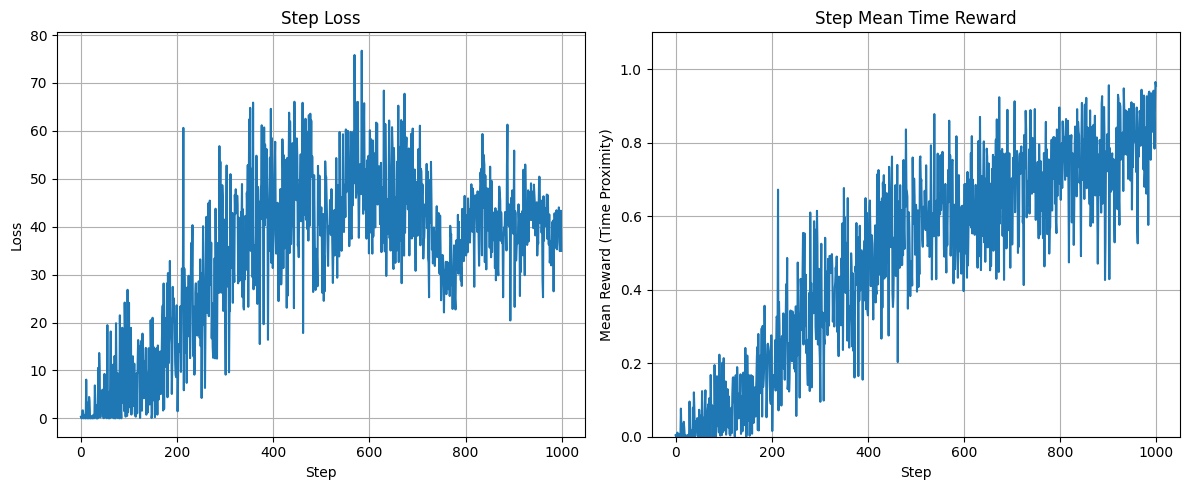

In [24]:
print("\n--- Analyzing Training Results ---")

# --- Plot Loss and Mean Reward Over Steps ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(step_losses)
plt.title("Step Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(step_mean_rewards)
plt.title("Step Mean Time Reward") # Updated Title
plt.xlabel("Step")
plt.ylabel("Mean Reward (Time Proximity)") # Updated Label
plt.ylim(0, 1.1) # Set ylim for reward typically 0-1
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Plot Histogram of Achieved Rewards ---
# This replaces the length histogram and the sparse reward bar chart
# plt.figure(figsize=(7, 5)) # Adjusted size for single plot

# # Use a histogram for the dense time rewards
# # Increase bins for better resolution of continuous reward values
# plt.hist(all_rewards, bins=25, range=(0, 1), density=True, alpha=0.75)
# plt.title("Distribution of Time Rewards (All Steps)") # Updated Title
# plt.xlabel("Time Proximity Reward") # Updated Label
# plt.ylabel("Density")
# plt.grid(axis='y')

# plt.tight_layout()
# plt.show()

In [25]:
# --- Example Generation After Training ---
print("\n--- Generating Example Sequence Post-Training ---")
model.eval() # Set model to evaluation mode
# Using a prompt that might encourage time generation
prompt_text = "<|startoftext|> What is the time in hh:mm?"
tokenizer.padding_side = "left" # Ensure consistency
inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Use the trained model for generation
trained_generation_kwargs = generation_kwargs.copy()
trained_generation_kwargs["max_new_tokens"] = 20 # Generate a short sequence
trained_generation_kwargs["output_scores"] = False
trained_generation_kwargs["return_dict_in_generate"] = False
trained_generation_kwargs["pad_token_id"] = tokenizer.pad_token_id # Ensure pad token is set

with torch.no_grad():
    output_sequences = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        **trained_generation_kwargs
    )

generated_tokens = output_sequences[0] # Get the first sequence in the batch
prompt_len = input_ids.shape[1]
generated_part_tokens = generated_tokens[prompt_len:]

# Decode for printing
generated_part_text = tokenizer.decode(generated_part_tokens, skip_special_tokens=False)
cleaned_text = generated_part_text.replace(tokenizer.eos_token, '<EOS>').replace(tokenizer.pad_token, '<PAD>')

# Calculate the reward for this specific generated sequence
# Ensure generated_part_tokens is on CPU for the reward function if model was on GPU
final_reward, final_extracted_time = calculate_time_reward(
    generated_ids=generated_part_tokens.to('cpu'), # Move to CPU if necessary
    tokenizer=tokenizer,
    sharpness=config.get("reward_sharpness", 0.05)
)

# Get the current time *now* for comparison context
current_eval_time_dt = datetime.datetime.now(tz)
current_eval_time_str = current_eval_time_dt.strftime("%H:%M:%S") # e.g., 20:23:08

# Print results for the example generation
print(f"Prompt: '{prompt_text}'")
print(f"Generated Text (raw): {generated_part_text}")
print(f"Generated Text (cleaned): {cleaned_text}")
print("-" * 20)
print(f"Current Time (at eval): {current_eval_time_str}")
print(f"Extracted Time from Generation: {final_extracted_time if final_extracted_time else 'None Found'}")
print(f"Calculated Time Reward for this Generation: {final_reward:.4f}")
print("-" * 20)


--- Generating Example Sequence Post-Training ---
Prompt: '<|startoftext|> What is the time in hh:mm?'
Generated Text (raw):  1937:38. 19:39 19: 31 19: 19: 19 19 1 19:
Generated Text (cleaned):  1937:38. 19:39 19: 31 19: 19: 19 19 1 19:
--------------------
Current Time (at eval): 19:40:35
Extracted Time from Generation: 19:39
Calculated Time Reward for this Generation: 0.9239
--------------------
